# importamos las bibliotecas necesarias

In [1]:
import pandas as pd
import ast
from textblob import TextBlob

In [2]:
# Lista para almacenar los diccionarios JSON de cada línea
data_list = []

# Ruta del archivo JSON
file_path = 'australian_user_reviews.json'

# Abrir el archivo y procesar cada línea
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            # Usar ast.literal_eval para convertir la línea en un diccionario
            json_data = ast.literal_eval(line)
            data_list.append(json_data)
        except ValueError as e:
            print(f"Error en la línea: {line}")
            continue

# Crear un DataFrame a partir de la lista de diccionarios
data_re = pd.DataFrame(data_list)



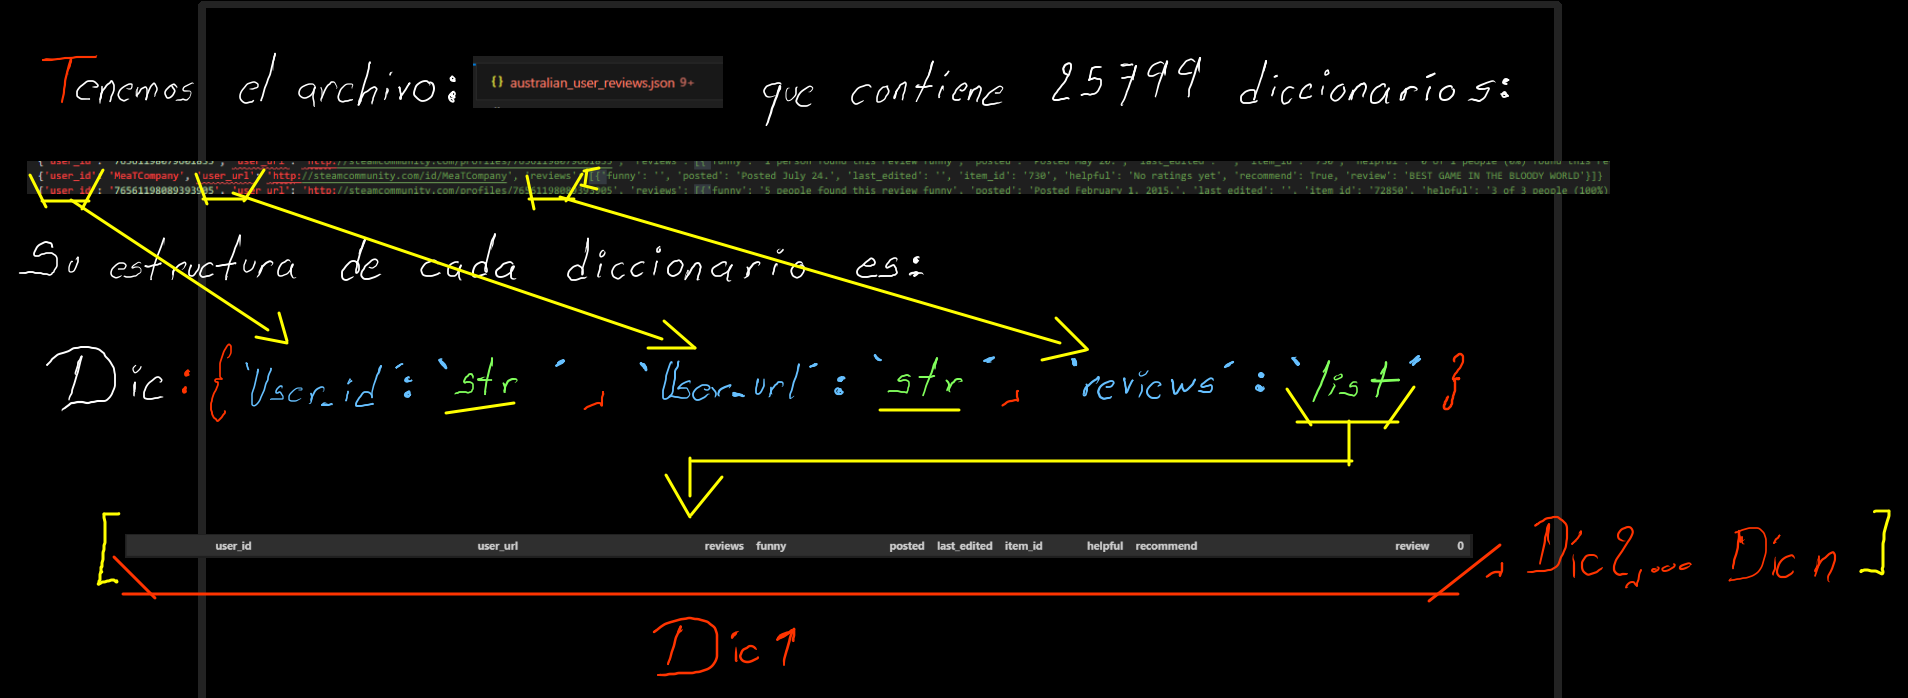

In [3]:
# se desanidan los datos de la columna ['reviews']
data_re1 = data_re.explode(['reviews'])
data_re2 = data_re1['reviews'].apply(pd.Series)
data_re3 = pd.concat([data_re1, data_re2], axis=1)

# se crea una columna nueva con el año extraido de los valores de la columna 'posted'
data_re3['year_posted'] = data_re3['posted'].str.extract('(\d{4})')

# se eliminan las columnas con poca relevancia para el posterior analisis
data_re3.drop(['reviews','user_url','last_edited','funny','helpful','posted'], axis=1, inplace = True)

# se eliminan valores nulos por colunas
data_re3 = data_re3.dropna(subset=['year_posted'])
data_re3 = data_re3.dropna(subset=['item_id'])
data_re3 = data_re3.dropna(subset=['review'])
data_re3 = data_re3.dropna(subset=['recommend'])

# seleccion de columnas relevantes para el analisis
data_re3 = data_re3[['user_id','item_id','review','recommend','year_posted',0]]

# reemplazar valores booleanos de T/F por 1/0 y cambiar el tipo de dato a 'int'
data_re3['recommend'] = data_re3['recommend'].replace({'False': 0, 'True': 1}).astype(int)

# borrar la ultima columna [0]
del data_re3[data_re3.columns[-1]]

# funcion que analisa el sentimiento con la libreria TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment < -0.1:
        return 0
    elif sentiment > 0.1:
        return 2
    else:
        return 1

# crea nueva columna 'sentiment_analysis'aplicando la funcion anterior sobre la columna 'review'
data_re3['sentiment_analysis'] = data_re3['review'].apply(get_sentiment)

# eliminar la columna 'review'
data_re3.drop(['review'], axis=1, inplace = True)

# se eliminan los duplicados y valores nulos en caso de haber
data_re3 = data_re3.drop_duplicates()
data_re3 = data_re3.dropna()

# se exporta la tabla como archivo separa por comas de nombre 'user_reviews'
data_re3.to_csv('user_reviews.csv', index=False)

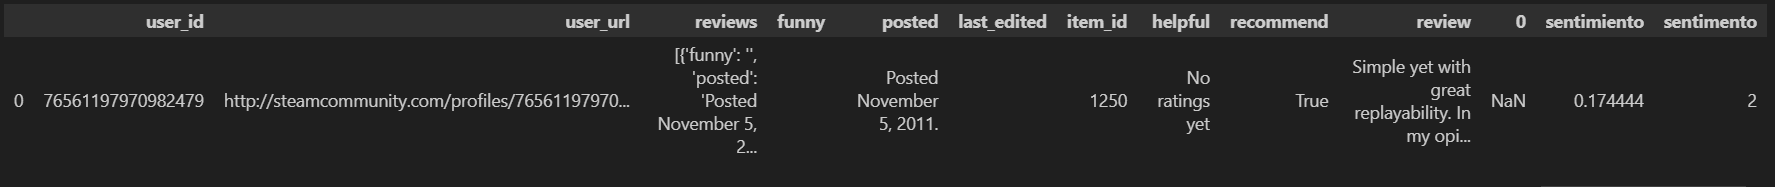